In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")

# Boosting libraries
import xgboost as xgb
from lightgbm import LGBMClassifier


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving diabetes_012_health_indicators_BRFSS2015.csv to diabetes_012_health_indicators_BRFSS2015.csv


In [ ]:
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nSample rows:")
display(df.head())

Dataset shape: (253680, 22)
Columns: ['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Sample rows:


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
df.isnull().sum()

,0
Diabetes_012,0
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
HeartDiseaseorAttack,0
PhysActivity,0
Fruits,0


In [ ]:
df['Diabetes_012'] = df['Diabetes_012'].astype(int)

In [ ]:
df['target'] = df['Diabetes_012'].apply(lambda x: 1 if x == 2 else 0)
print("\nTarget distribution (binary):")
print(df['target'].value_counts())


Target distribution (binary):
target
0    218334
1     35346
Name: count, dtype: int64


In [ ]:
#Drop original target column and any obvious non-predictive columns
df_model = df.copy()
df_model.drop(columns=['Diabetes_012'], inplace=True)

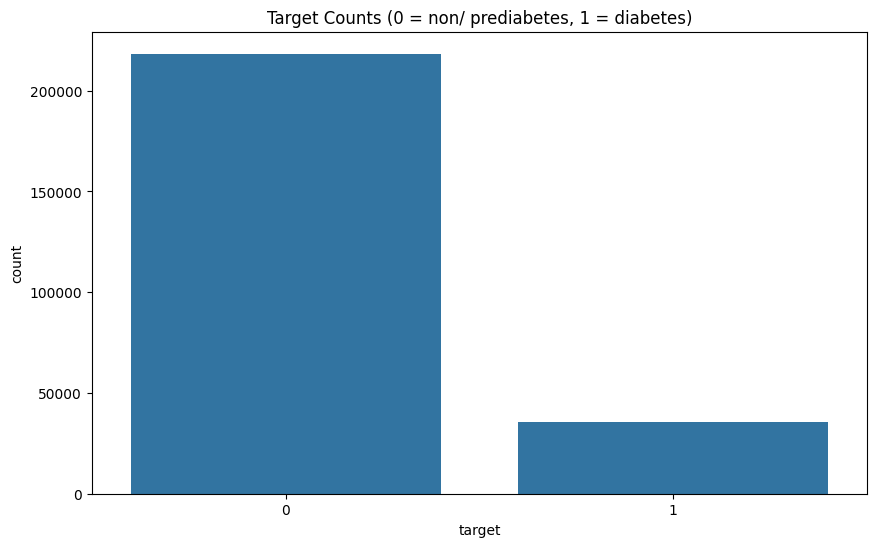

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='target', data=df_model)
plt.title("Target Counts (0 = non/ prediabetes, 1 = diabetes)")
plt.show()

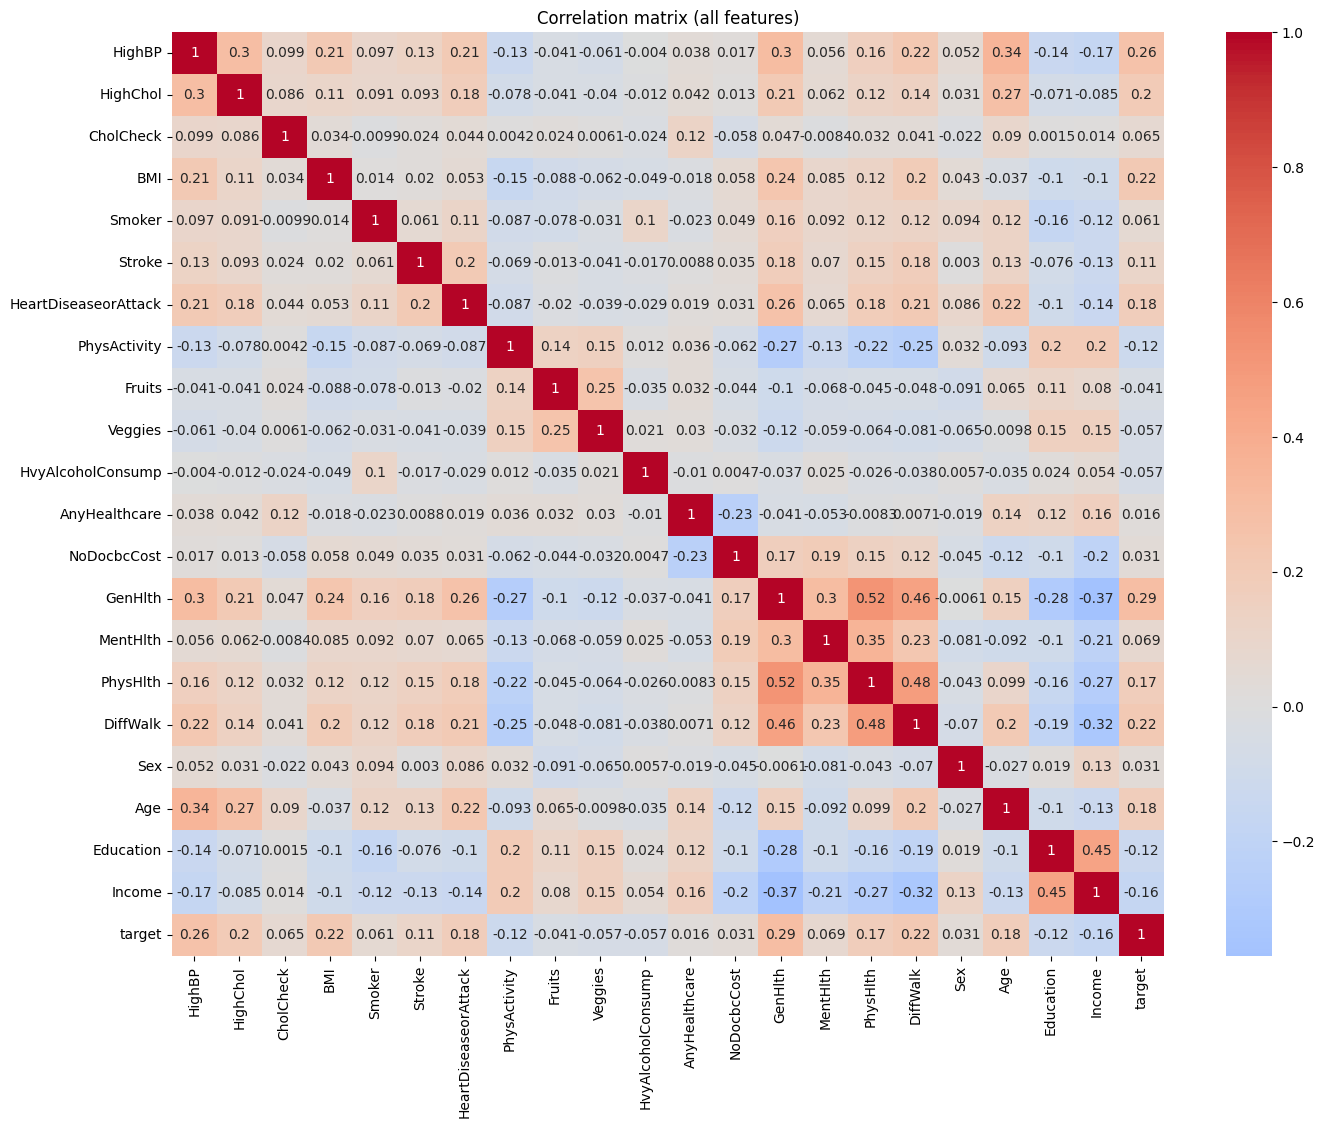

In [ ]:
# Show correlation heatmap (only numeric)
plt.figure(figsize=(16,12))
sns.heatmap(df_model.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation matrix (all features)")
plt.show()

In [ ]:
drop_features = ['CholCheck', 'AnyHealthcare', 'NoDocbcCost', 'Sex', 'Education', 'Income']

# Split data into features (X) and target (y)
X = df_model.drop(columns=['target'] + drop_features).copy()
y = df_model['target'].copy()

In [ ]:
# Ensure all features are numeric; convert if necessary
for c in X.columns:
    if X[c].dtype == 'object':
        try:
            X[c] = pd.to_numeric(X[c])
        except:
            X[c] = X[c].astype('category').cat.codes

print("\nFeature dtypes after conversion:")
display(X.dtypes.value_counts())


Feature dtypes after conversion:


,count
float64,15


In [ ]:
#Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("\nTrain/test sizes:", X_train.shape, X_test.shape)


Train/test sizes: (202944, 15) (50736, 15)


In [ ]:
# Address class imbalance using SMOTE on the training set only
print("\nBefore SMOTE class distribution:", y_train.value_counts().to_dict())
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("After SMOTE class distribution:", y_train_sm.value_counts().to_dict())


Before SMOTE class distribution: {0: 174667, 1: 28277}
After SMOTE class distribution: {0: 174667, 1: 174667}


In [ ]:
# Feature selection using a LightGBM-based importance selector
# Train a quick LightGBM to get importances for selection
selector_lgb = LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
selector_lgb.fit(X_train_sm, y_train_sm)
importances = selector_lgb.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nTop 20 feature importances (LightGBM quick run):")
display(feat_imp.head(20))

[LightGBM] [Info] Number of positive: 174667, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 349334, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Top 20 feature importances (LightGBM quick run):


,0
Age,1207
BMI,1105
GenHlth,971
PhysHlth,316
HighBP,299
MentHlth,288
HighChol,265
DiffWalk,259
HeartDiseaseorAttack,230
PhysActivity,228


In [ ]:
selected_feats = [
    'Age', 'BMI', 'GenHlth', 'PhysHlth', 'HighBP', 'MentHlth',
    'HighChol', 'DiffWalk', 'HeartDiseaseorAttack', 'PhysActivity',
    'Veggies', 'HvyAlcoholConsump', 'Stroke', 'Smoker', 'Fruits'
]

print("\nSelected features for final training:", selected_feats)


Selected features for final training: ['Age', 'BMI', 'GenHlth', 'PhysHlth', 'HighBP', 'MentHlth', 'HighChol', 'DiffWalk', 'HeartDiseaseorAttack', 'PhysActivity', 'Veggies', 'HvyAlcoholConsump', 'Stroke', 'Smoker', 'Fruits']


In [ ]:
# Reduce datasets to selected features
X_train_sel = X_train_sm[selected_feats]
X_test_sel = X_test[selected_feats]

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_sel)
X_train_scaled = scaler.transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

In [ ]:
from xgboost.callback import EarlyStopping
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    # These two lines are the fix:
    early_stopping_rounds=50
)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train_sm, test_size=0.15, stratify=y_train_sm, random_state=42)

In [ ]:
xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-auc:0.87965
[1]	validation_0-auc:0.89346
[2]	validation_0-auc:0.89596
[3]	validation_0-auc:0.90010
[4]	validation_0-auc:0.90231
[5]	validation_0-auc:0.90274
[6]	validation_0-auc:0.90359
[7]	validation_0-auc:0.90271
[8]	validation_0-auc:0.90370
[9]	validation_0-auc:0.90383
[10]	validation_0-auc:0.90427
[11]	validation_0-auc:0.90559
[12]	validation_0-auc:0.90572
[13]	validation_0-auc:0.90571
[14]	validation_0-auc:0.90657
[15]	validation_0-auc:0.90713
[16]	validation_0-auc:0.90799
[17]	validation_0-auc:0.90864
[18]	validation_0-auc:0.90956
[19]	validation_0-auc:0.91103
[20]	validation_0-auc:0.91173
[21]	validation_0-auc:0.91163
[22]	validation_0-auc:0.91216
[23]	validation_0-auc:0.91371
[24]	validation_0-auc:0.91441
[25]	validation_0-auc:0.91502
[26]	validation_0-auc:0.91556
[27]	validation_0-auc:0.91597
[28]	validation_0-auc:0.91665
[29]	validation_0-auc:0.91721
[30]	validation_0-auc:0.91743
[31]	validation_0-auc:0.91764
[32]	validation_0-auc:0.91828
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# Predict and evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:,1]

print("\n=== XGBoost Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 (binary):", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm)


=== XGBoost Performance ===
Accuracy: 0.8564333017975402
F1 (binary): 0.3202687569988802
ROC-AUC: 0.8108174589098116

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     43667
           1       0.47      0.24      0.32      7069

    accuracy                           0.86     50736
   macro avg       0.68      0.60      0.62     50736
weighted avg       0.83      0.86      0.84     50736

Confusion Matrix:
 [[41736  1931]
 [ 5353  1716]]


In [ ]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

lgbm_model = LGBMClassifier(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=40,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

In [ ]:
# Prepare eval set using raw (not scaled) selected features from SMOTE train
X_train_sel_raw = X_train_sel.values
# split into train/val
X_tr_raw, X_val_raw, y_tr_raw, y_val_raw = train_test_split(
    X_train_sel_raw, y_train_sm, test_size=0.15, stratify=y_train_sm, random_state=42
)

In [ ]:
lgbm_model.fit(
    X_tr_raw, y_tr_raw,
    eval_set=[(X_val_raw, y_val_raw)],
    callbacks=[
        early_stopping(stopping_rounds=100, verbose=True),  # Stops + prints
        log_evaluation(period=100)  # Prints every 100 iterations
    ]
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.322416
[200]	valid_0's binary_logloss: 0.249239
[300]	valid_0's binary_logloss: 0.226655
[400]	valid_0's binary_logloss: 0.218917
[500]	valid_0's binary_logloss: 0.215676
[600]	valid_0's binary_logloss: 0.213779
[700]	valid_0's binary_logloss: 0.212237
[800]	valid_0's binary_logloss: 0.211067
[900]	valid_0's binary_logloss: 0.210142
[1000]	valid_0's binary_logloss: 0.209529
[1100]	valid_0's binary_logloss: 0.209083
[1200]	valid_0's binary_logloss: 0.208651
[1300]	valid_0's binary_logloss: 0.208215
[1400]	valid_0's binary_logloss: 0.207703
[1500]	valid_0's binary_logloss: 0.207315
[1600]	valid_0's binary_logloss: 0.207072
[1700]	valid_0's binary_logloss: 0.2068
[1800]	valid_0's binary_logloss: 0.206665
[1900]	valid_0's binary_logloss: 0.206531
[2000]	valid_0's binary_logloss: 0.206401
[2100]	valid_0's binary_logloss: 0.206306
[2200]	valid_0's binary_logloss: 0.206235
[2300]	valid_0's binary_l

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.03, n_estimators=10000,
               n_jobs=-1, num_leaves=40, random_state=42, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.8, verbosity=-1)

In [ ]:
# Predict and evaluate LightGBM
y_pred_lgb = lgbm_model.predict(X_test_sel)
y_proba_lgb = lgbm_model.predict_proba(X_test_sel)[:,1]

print("\n=== LightGBM Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("F1 (binary):", f1_score(y_test, y_pred_lgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb))
cm_l = confusion_matrix(y_test, y_pred_lgb)
print("Confusion Matrix:\n", cm_l)



=== LightGBM Performance ===
Accuracy: 0.8573990854619994
F1 (binary): 0.30184309562867895
ROC-AUC: 0.8094673268355508

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     43667
           1       0.47      0.22      0.30      7069

    accuracy                           0.86     50736
   macro avg       0.68      0.59      0.61     50736
weighted avg       0.83      0.86      0.83     50736

Confusion Matrix:
 [[41937  1730]
 [ 5505  1564]]


In [ ]:
#Compare and save best model (by ROC-AUC)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
auc_lgb = roc_auc_score(y_test, y_proba_lgb)
print(f"\nAUC XGBoost: {auc_xgb:.4f}  |  AUC LightGBM: {auc_lgb:.4f}")


AUC XGBoost: 0.8108  |  AUC LightGBM: 0.8095


In [ ]:
if auc_lgb >= auc_xgb:
    best_model = lgbm_model
    best_name = "lightgbm"
    # Save using joblib
    joblib.dump(best_model, "models/diabetes_lightgbm.pkl") if os.path.exists("models") else (os.makedirs("models") or joblib.dump(best_model, "models/diabetes_lightgbm.pkl"))
    print("Saved best model: LightGBM")
else:
    best_model = xgb_model
    best_name = "xgboost"
    joblib.dump(best_model, "models/diabetes_xgboost.pkl") if os.path.exists("models") else (os.makedirs("models") or joblib.dump(best_model, "models/diabetes_xgboost.pkl"))
    print("Saved best model: XGBoost")

Saved best model: XGBoost


In [ ]:
# Save scaler and selected feature list
joblib.dump(scaler, "models/diabetes_scaler.pkl")
joblib.dump(selected_feats, "models/diabetes_selected_features.pkl")

['models/diabetes_selected_features.pkl']

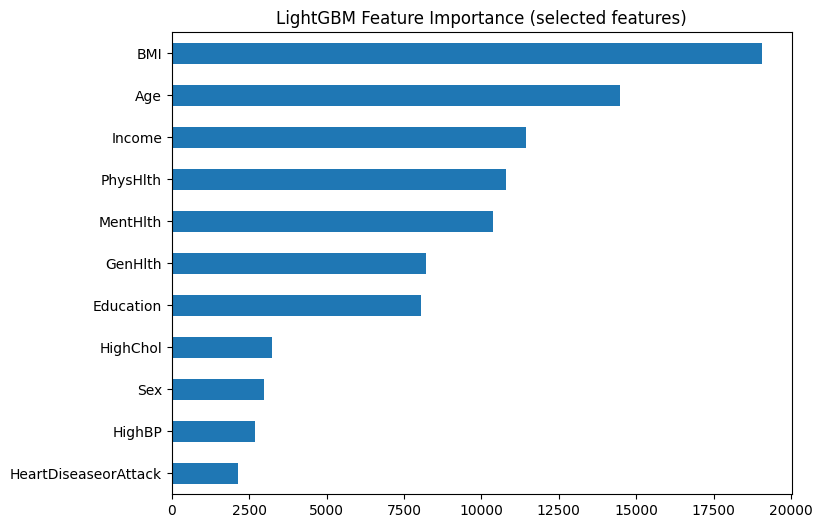

In [ ]:
# LightGBM importance
plt.figure(figsize=(8,6))
feat_imp_lgb = pd.Series(lgbm_model.feature_importances_, index=selected_feats).sort_values(ascending=True)
feat_imp_lgb.plot(kind='barh')
plt.title("LightGBM Feature Importance (selected features)")
plt.show()

In [ ]:
import joblib
import os

os.makedirs("models", exist_ok=True)
joblib.dump(xgb_model, "models/diabetes_xgboost.pkl")

['models/diabetes_xgboost.pkl']

In [ ]:
from google.colab import files
files.download("models/diabetes_xgboost.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(scaler, "models/diabetes_scaler.pkl")
joblib.dump(selected_feats, "models/diabetes_selected_features.pkl")

['models/diabetes_selected_features.pkl']

In [ ]:
files.download("models/diabetes_scaler.pkl")
files.download("models/diabetes_selected_features.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>